In [1]:

from pyspark.mllib.recommendation import ALS, Rating
from pyspark.rdd import RDD
from pyspark.sql import SparkSession, Row
import random
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("MovieLensReader") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [7]:

rawUD = sc.textFile("u.data")
rawRatings = rawUD.map(lambda line: line.split("\t")[:3])
ratingsRDD = rawRatings.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))


In [8]:
from pyspark.sql import functions as F

df = ratingsRDD.toDF()
# Step 1: Identify all users
user_counts = df.groupBy("user").agg(F.count("*").alias("count"))
eligible_users = user_counts.filter("count >= 5").select("user").rdd.flatMap(lambda x: x).collect()

# Step 2: Sample OOD users from users with sufficient data
ood_users = set(random.sample(eligible_users, int(0.2 * len(eligible_users))))
id_users = set(eligible_users) - ood_users

# Step 3: Keep all data from ID users in training
train_df = df.filter(df['user'].isin(list(id_users)))
test_id_rdd = train_df.rdd.map(lambda row: ((row['user'], row['product']), row['rating']))

# Step 4: For OOD users: split their data into 80% train, 20% test
ood_df = df.filter(df['user'].isin(list(ood_users)))

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

# Step 1: Add row numbers within each OOD user
window = Window.partitionBy("user").orderBy(F.rand())
ood_df = ood_df.withColumn("row_num", row_number().over(window))

# Step 2: Get rating count per user
user_counts_df = ood_df.groupBy("user").agg(F.count("*").alias("rating_count"))

# Step 3: Join back with ood_df to add count column
ood_df = ood_df.join(user_counts_df, on="user")

# Step 4: Filter 80% train, 20% test per user
ood_train = ood_df.filter(col("row_num") <= (0.8 * col("rating_count")))
ood_test = ood_df.filter(col("row_num") > (0.8 * col("rating_count")))

In [10]:
# Final training = ID training + OOD partial
ood_train = ood_train.select("user", "product", "rating")
final_train_df = train_df.union(ood_train)
test_ood_rdd = ood_test.rdd.map(lambda row: ((row['user'], row['product']), row['rating']))

In [11]:
train_rdd = final_train_df.rdd.map(lambda row: Rating(row['user'], row['product'], row['rating']))
model = ALS.train(train_rdd, rank=10, iterations=10, lambda_=0.01)


In [ ]:
# Evaluate on ID users
pred_id = model.predictAll(test_id_rdd.map(lambda x: x[0]))
pred_id_kv = pred_id.map(lambda r: ((r.user, r.product), r.rating))
joined_id = pred_id_kv.join(test_id_rdd)

id_results = joined_id.map(lambda x: (x[1][1], x[1][0])).collect()
if id_results:
    true_id, pred_id = zip(*id_results)
else:
    print("No matching ID predictions.")
    true_id, pred_id = [], []

# Evaluate on OOD users
pred_ood = model.predictAll(test_ood_rdd.map(lambda x: x[0]))
pred_ood_kv = pred_ood.map(lambda r: ((r.user, r.product), r.rating))
joined_ood = pred_ood_kv.join(test_ood_rdd)

ood_results = joined_ood.map(lambda x: (x[1][1], x[1][0])).collect()
if ood_results:
    true_ood, pred_ood = zip(*ood_results)
else:
    print("No matching OOD predictions. Possibly due to cold start.")
    true_ood, pred_ood = [], []


In [13]:

def evaluate_predictions(y_true, y_pred):
    metrics = {}
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    metrics['Accuracy'] = 100 - mape
    return metrics


In [14]:

rmse_id = evaluate_predictions(true_id, pred_id)['RMSE']
mae_id = evaluate_predictions(true_id, pred_id)['MAE']
rmse_ood = evaluate_predictions(true_ood, pred_ood)['RMSE']
mae_ood = evaluate_predictions(true_ood, pred_ood)['MAE']

print(f"In-Distribution (ID) → RMSE: {rmse_id:.4f}, MAE: {mae_id:.4f}")
print(f"Out-of-Distribution (OOD) → RMSE: {rmse_ood:.4f}, MAE: {mae_ood:.4f}")


In-Distribution (ID) → RMSE: 0.6896, MAE: 0.5322
Out-of-Distribution (OOD) → RMSE: 1.0583, MAE: 0.7981


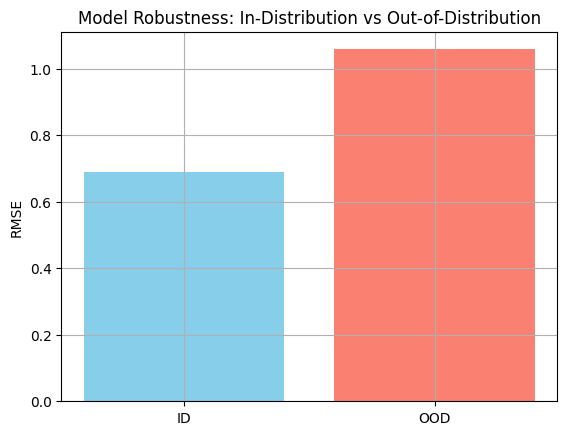

In [15]:

plt.bar(['ID', 'OOD'], [rmse_id, rmse_ood], color=['skyblue', 'salmon'])
plt.ylabel("RMSE")
plt.title("Model Robustness: In-Distribution vs Out-of-Distribution")
plt.grid(True)
plt.show()


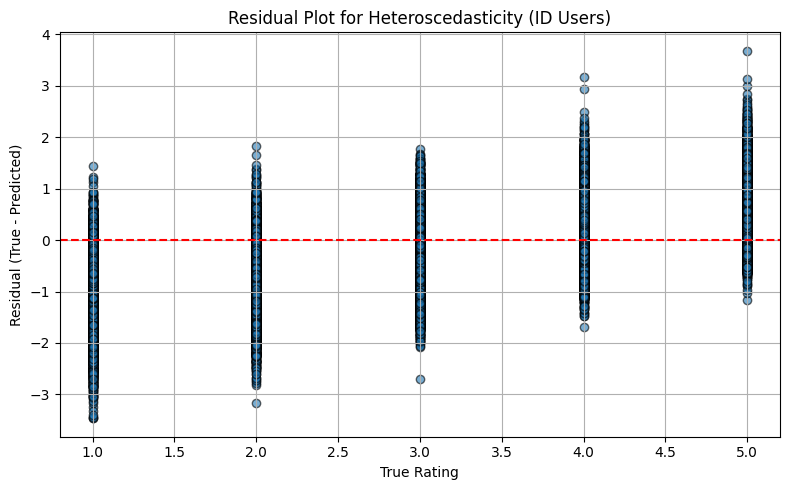

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ID residual plot
residuals_id = np.array(true_id) - np.array(pred_id)

plt.figure(figsize=(8, 5))
plt.scatter(true_id, residuals_id, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Rating")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot for Heteroscedasticity (ID Users)")
plt.grid(True)
plt.tight_layout()
plt.show()


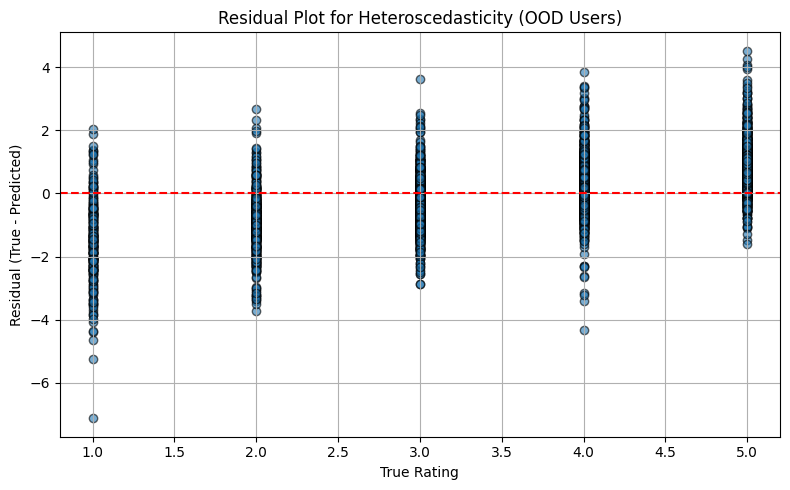

In [20]:
# OOD residual plot
residuals_ood = np.array(true_ood) - np.array(pred_ood)

plt.figure(figsize=(8, 5))
plt.scatter(true_ood, residuals_ood, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Rating")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot for Heteroscedasticity (OOD Users)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.mllib.recommendation import ALS, Rating
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col, count
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def run_double_descent(df, id_users, ranks):
    # 1. Filter ID user data only
    id_only_df = df.filter(col("user").isin(list(id_users)))

    # 2. Assign row numbers for each user to split 80/20
    id_window = Window.partitionBy("user").orderBy(F.rand())
    id_only_df = id_only_df.withColumn("row_num", row_number().over(id_window))

    # 3. Add count of ratings per user
    user_rating_counts = id_only_df.groupBy("user").agg(count("*").alias("rating_count"))
    id_only_df = id_only_df.join(user_rating_counts, on="user")

    # 4. Train/test split
    id_train_df = id_only_df.filter(col("row_num") <= 0.8 * col("rating_count"))
    id_val_df = id_only_df.filter(col("row_num") > 0.8 * col("rating_count"))

    # 5. Create RDDs
    train_rdd = id_train_df.select("user", "product", "rating") \
        .rdd.map(lambda row: Rating(row['user'], row['product'], row['rating']))

    test_id_rdd = id_val_df.select("user", "product", "rating") \
        .rdd.map(lambda row: ((row['user'], row['product']), row['rating']))

    # 6. Run ALS for each rank
    rmse_scores = []

    validation_rdd = test_id_rdd.map(lambda x: x[0])  # (user, product)

    for rank in ranks:
        model = ALS.train(train_rdd, rank=rank, iterations=10, lambda_=0.01)
        predictions = model.predictAll(validation_rdd)
        predicted_rdd = predictions.map(lambda r: ((r.user, r.product), r.rating))

        joined = predicted_rdd.join(test_id_rdd)
        results = joined.map(lambda x: (x[1][1], x[1][0])).collect()

        if results:
            y_true, y_pred = zip(*results)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        else:
            rmse = np.nan  
        rmse_scores.append(rmse)
        print(f"Rank={rank}  RMSE={rmse:.4f}" if not np.isnan(rmse) else f"Rank={rank}  No predictions")

    # 7. Plot the double descent curve
    plt.figure(figsize=(8, 5))
    plt.plot(ranks, rmse_scores, marker='o')
    plt.title("Double Descent Curve (ALS Rank vs RMSE)")
    plt.xlabel("ALS Rank (Latent Factors)")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()


Rank=2 → RMSE=0.9511
Rank=4 → RMSE=1.0017
Rank=10 → RMSE=1.1160
Rank=20 → RMSE=1.2155
Rank=40 → RMSE=1.2549
Rank=80 → RMSE=1.1878
Rank=100 → RMSE=1.1743


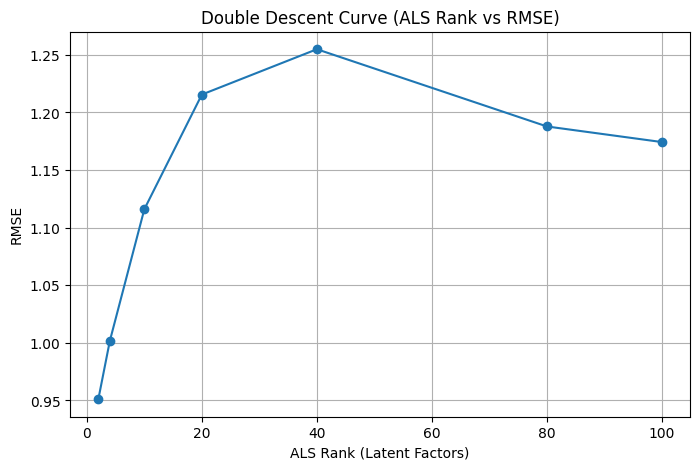

In [18]:
ranks = [2, 4, 10, 20, 40, 80, 100]
run_double_descent(df, id_users, ranks)


In [ ]:
import numpy as np
from collections import defaultdict

def precision_recall_at_k_als(user_item_true, user_item_pred, K=10, threshold=4.0):

    precisions = []
    recalls = []

    for user in user_item_true:
        gt_items = set(user_item_true[user])
        if not gt_items:
            continue

        ranked_items = sorted(user_item_pred[user], key=lambda x: x[1], reverse=True)
        top_k_items = set([item for item, _ in ranked_items[:K]])

        hits = gt_items & top_k_items
        precisions.append(len(hits) / K)
        recalls.append(len(hits) / len(gt_items))

    return np.mean(precisions), np.mean(recalls)


In [29]:
pred_id = model.predictAll(test_id_rdd.map(lambda x: x[0]))

print(type(pred_id))


<class 'pyspark.rdd.RDD'>


In [30]:
# 1. Ground truth items rated ≥ 4
test_relevant = test_id_rdd \
    .filter(lambda x: x[1] >= 4.0) \
    .map(lambda x: (x[0][0], x[0][1])) \
    .groupByKey() \
    .mapValues(list) \
    .collectAsMap()

# 2. Predicted items per user
pred_user_items = pred_id.map(lambda row: (row.user, (row.product, row.rating))) \
                         .groupByKey() \
                         .mapValues(list) \
                         .collectAsMap()



In [32]:
precision, recall = precision_recall_at_k_als(test_relevant, pred_user_items, K=10)
print(f"Precision@10: {precision:.4f}, Recall@10: {recall:.4f}")

Precision@10: 0.9330, Recall@10: 0.3320
